[*********************100%***********************]  1 of 1 completed

Epoch 1/30



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - loss: 0.0608 - val_loss: 0.0012
Epoch 2/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0040 - val_loss: 7.7474e-04
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0037 - val_loss: 4.6375e-04
Epoch 4/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0032 - val_loss: 7.4339e-04
Epoch 5/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0025 - val_loss: 4.6290e-04
Epoch 6/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 0.0024 - val_loss: 3.4710e-04
Epoch 7/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0019 - val_loss: 3.3479e-04
Epoch 8/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0021 - val_loss: 0.0011
Epoch 9/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0024 - val_loss: 3.3214e-04
Epoch 10/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0018 - val_loss: 4.9321e-04
Epoch 11/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 0.0019 - val_loss: 8.2393e-04
Epoch 12/30
44/44 ━━━━━━━━━━━━━━━━━━━━

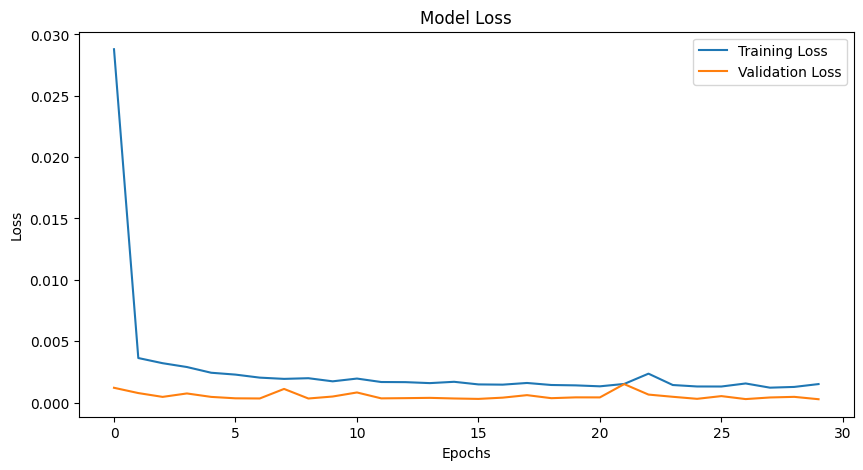

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
RMSE: 3.134579981490717
R² Score: 0.9968357759392019


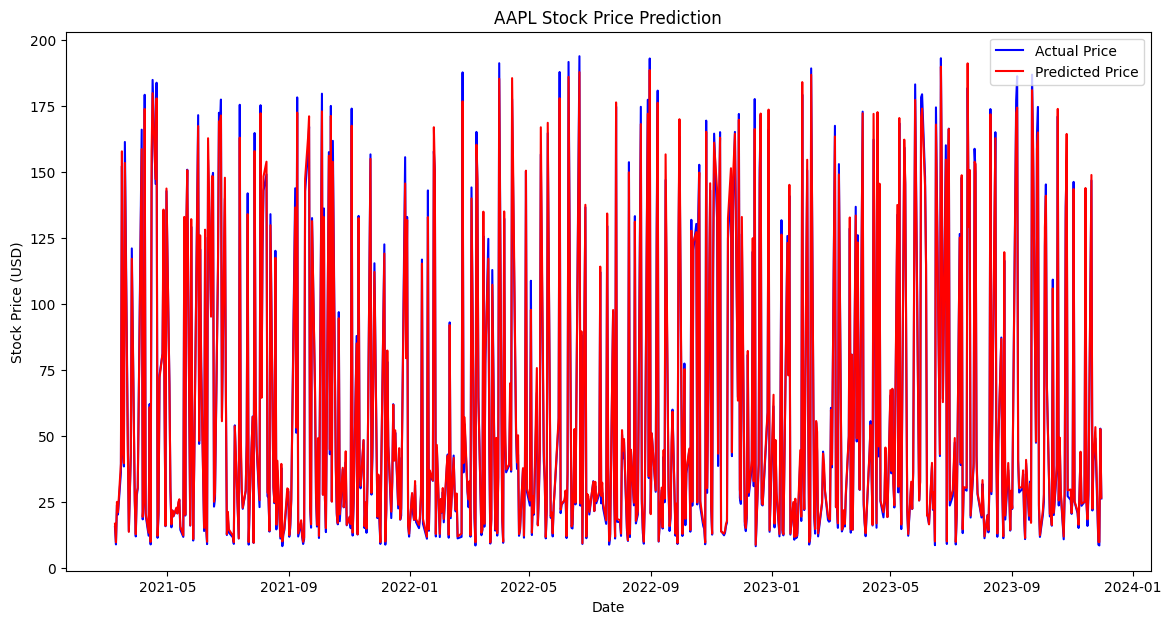

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted Next Day Price: $187.59


In [3]:
# Install required libraries
!pip install yfinance
!pip install tensorflow

# Import necessary libraries
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Step 1: Fetch Historical Stock Data
stock_symbol = "AAPL"  # Example: Apple stock
start_date = "2010-01-01"
end_date = "2023-12-01"

data = yf.download(stock_symbol, start=start_date, end=end_date)
data.reset_index(inplace=True)

# Step 2: Data Preprocessing
# Use 'Close' prices for prediction
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data = data[['Close']]

# Scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create sequences for LSTM
def create_sequences(data, seq_length):
    x, y = [], []
    for i in range(seq_length, len(data)):
        x.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(x), np.array(y)

seq_length = 60  # Look back 60 days
x, y = create_sequences(scaled_data, seq_length)

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Reshape for LSTM (samples, time steps, features)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Step 3: Build the LSTM Model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)),
    Dropout(0.3),
    LSTM(50, return_sequences=False),
    Dropout(0.3),
    Dense(25),
    Dense(1)
])


# Compile the model
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error')

# Train the model
history = model.fit(x_train, y_train, batch_size=64, epochs=30, validation_data=(x_test, y_test))

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Step 4: Evaluate the Model
# Predict on the test set
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))  # Rescale predictions

# Rescale the actual test values
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test_scaled, predictions))
r2 = r2_score(y_test_scaled, predictions)

print(f"RMSE: {rmse}")
print(f"R² Score: {r2}")

# Step 5: Visualize Predictions
plt.figure(figsize=(14, 7))
plt.plot(data.index[-len(y_test):], y_test_scaled, label="Actual Price", color="blue")
plt.plot(data.index[-len(y_test):], predictions, label="Predicted Price", color="red")
plt.title(f"{stock_symbol} Stock Price Prediction")
plt.xlabel("Date")
plt.ylabel("Stock Price (USD)")
plt.legend()
plt.show()

# Step 6: Predict Future Price
last_60_days = scaled_data[-60:]
last_60_days = last_60_days.reshape(1, -1, 1)

future_prediction = model.predict(last_60_days)
future_prediction = scaler.inverse_transform(future_prediction)

print(f"Predicted Next Day Price: ${future_prediction[0][0]:.2f}")
